In [2]:
import optuna
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, \
                            f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pickle

In [4]:
# Muat data mentah
with open("train_test_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train, X_test, y_train, y_test = data["X_train"], data["X_test"], data["y_train"], data["y_test"]

# Muat preprocessing pipeline (unfitted)
with open("preprocessing_pipeline.pkl", "rb") as f:
    preprocess = pickle.load(f)

# Muat best params
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

In [7]:
seed=42
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# Buat pipeline base models (belum di-fit!)
xgb_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(**best_params["xgb"], scale_pos_weight=scale_pos_weight, random_state=seed, n_jobs=-1))
])

lasso_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(**best_params["lasso"], random_state=seed, n_jobs=-1))
])

## Bangun Meta Learner (Ridge)


In [8]:
# ============================================================
# parameter untuk meta learner
# ============================================================
meta_lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=2000,
    class_weight='balanced',
    random_state=seed
)

## Stacking


In [9]:
# ============================================================
# Bangun Ulang Model Stacking
# ============================================================

skf_stacking = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# Pasang di Stacking
final_stack = StackingClassifier(
    estimators=[
        ('lasso', lasso_pipe),
        ('xgb', xgb_pipe)
    ],
    final_estimator=meta_lr,
    cv=skf_stacking,
    n_jobs=-1,
)

final_stack.fit(X_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('lasso', ...), ('xgb', ...)]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegre...ndom_state=42)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",StratifiedKFo... shuffle=True)
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can refe

In [10]:
def evaluate_cv_stability(model, X, y, cv, model_name="Model"):
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    mean_auc = scores.mean()
    std_auc = scores.std()

    print(f"{model_name}")
    print(f"ROC-AUC CV Mean : {mean_auc:.4f}")
    print(f"ROC-AUC CV Std  : {std_auc:.4f}")
    print("-" * 40)

    return mean_auc, std_auc


# Evaluasi Model

In [11]:
# ============================================================
# FUNGSI EVALUASI
# ============================================================
def evaluate_model_full(y_true, y_proba, name="Model"):
    roc_auc = roc_auc_score(y_true, y_proba)
    y_pred = (y_proba >= 0.5).astype(int)

    recall_fraud = recall_score(y_true, y_pred, pos_label=1)
    precision_fraud = precision_score(y_true, y_pred, pos_label=1)
    f1_fraud = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"=== {name} ===")
    print(f" ROC-AUC            : {roc_auc:.4f}")
    print(f" Accuracy           : {accuracy:.4f}")
    print(f" Precision (Fraud)  : {precision_fraud:.4f}")
    print(f" Recall (Fraud)     : {recall_fraud:.4f}")
    print(f" F1-Score (Fraud)   : {f1_fraud:.4f}")
    print(f" Specificity (Non-F): {specificity:.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 60)

In [12]:
# ============================================================
# EVALUASI: STACKING (data test)
# ============================================================

y_proba_stack = final_stack.predict_proba(X_test)[:, 1]

evaluate_model_full(y_test, y_proba_stack,
                    "Hybrid Stacking (Lasso + XGB → LR)")


=== Hybrid Stacking (Lasso + XGB → LR) ===
 ROC-AUC            : 0.8518
 Accuracy           : 0.8367
 Precision (Fraud)  : 0.6344
 Recall (Fraud)     : 0.7973
 F1-Score (Fraud)   : 0.7066
 Specificity (Non-F): 0.8496
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       226
           1       0.63      0.80      0.71        74

    accuracy                           0.84       300
   macro avg       0.78      0.82      0.80       300
weighted avg       0.86      0.84      0.84       300

------------------------------------------------------------


In [13]:
# ============================================================
# EVALUASI: STACKING (data train)
# ============================================================

y_proba_stack_train = final_stack.predict_proba(X_train)[:, 1]

evaluate_model_full(y_train, y_proba_stack_train,
                    "Hybrid Stacking (Lasso + XGB → LR)")

=== Hybrid Stacking (Lasso + XGB → LR) ===
 ROC-AUC            : 0.9448
 Accuracy           : 0.8670
 Precision (Fraud)  : 0.6724
 Recall (Fraud)     : 0.9017
 F1-Score (Fraud)   : 0.7704
 Specificity (Non-F): 0.8555
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       526
           1       0.67      0.90      0.77       173

    accuracy                           0.87       699
   macro avg       0.82      0.88      0.84       699
weighted avg       0.89      0.87      0.87       699

------------------------------------------------------------


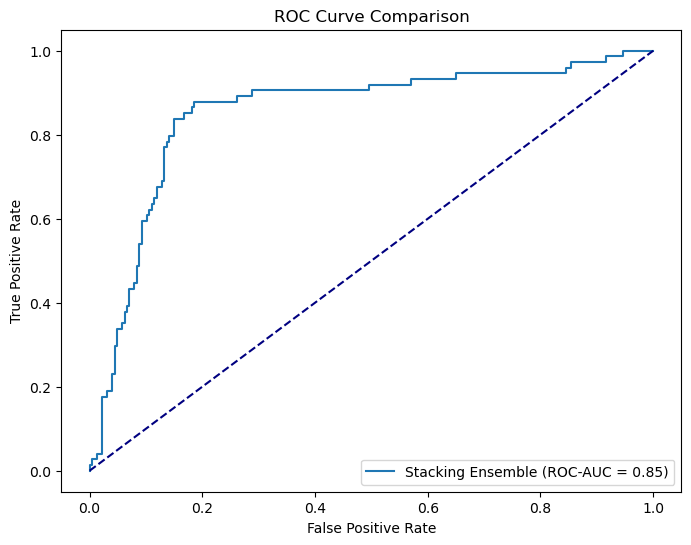

In [14]:
# Menghitung probabilitas untuk tiap model
y_proba_stack = final_stack.predict_proba(X_test)[:, 1]

# Menghitung ROC curve untuk tiap model
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, label='Stacking Ensemble (ROC-AUC = %0.2f)' % roc_auc_score(y_test, y_proba_stack))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


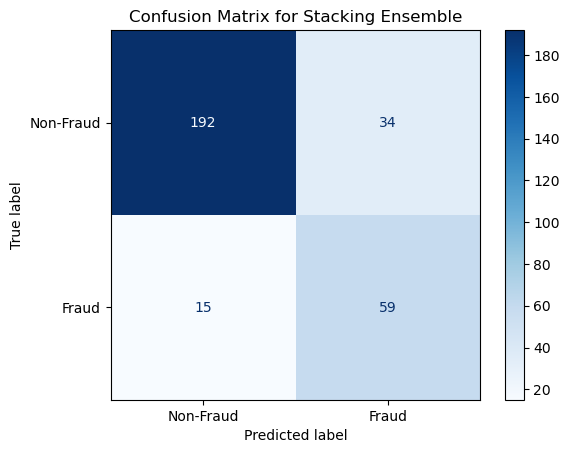

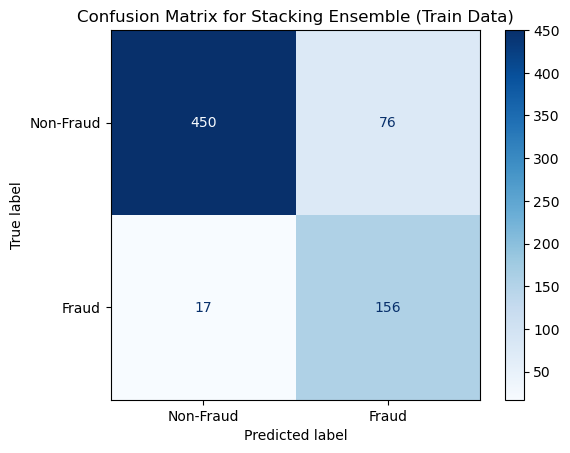

In [15]:
# Confusion Matrix untuk Stacking
cm_stack = confusion_matrix(y_test, (y_proba_stack >= 0.5).astype(int))
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=["Non-Fraud", "Fraud"])
disp_stack.plot(cmap="Blues")
plt.title("Confusion Matrix for Stacking Ensemble")
plt.show()

y_train_proba_stack = final_stack.predict_proba(X_train)[:, 1]
# Confusion Matrix for Stacking on training data
cm_train_stack = confusion_matrix(y_train, (y_train_proba_stack >= 0.5).astype(int))
disp_train_stack = ConfusionMatrixDisplay(confusion_matrix=cm_train_stack, display_labels=["Non-Fraud", "Fraud"])
disp_train_stack.plot(cmap="Blues")
plt.title("Confusion Matrix for Stacking Ensemble (Train Data)")
plt.show()

In [16]:
# Lihat bobot
print("Bobot Lasso  :", final_stack.final_estimator_.coef_[0][0])
print("Bobot XGBoost:", final_stack.final_estimator_.coef_[0][1])

Bobot Lasso  : 0.3132947146966179
Bobot XGBoost: 6.505439975363152


# info tambahan

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Stacking
stack_mean, stack_std = evaluate_cv_stability(
    final_stack,
    X_train,
    y_train,
    cv,
    model_name="Stacking Ensemble"
)


Stacking Ensemble
ROC-AUC CV Mean : 0.8855
ROC-AUC CV Std  : 0.0187
----------------------------------------


In [19]:
#overfitting check
print("data test")
y_proba_stack = final_stack.predict_proba(X_test)[:, 1]
evaluate_model_full(y_test, y_proba_stack, "Hybrid Stacking")

print("data train")
y_proba_stack_train = final_stack.predict_proba(X_train)[:, 1]
evaluate_model_full(y_train, y_proba_stack_train, "Hybrid Stacking (Train)")

data test
=== Hybrid Stacking ===
 ROC-AUC            : 0.8518
 Accuracy           : 0.8367
 Precision (Fraud)  : 0.6344
 Recall (Fraud)     : 0.7973
 F1-Score (Fraud)   : 0.7066
 Specificity (Non-F): 0.8496
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       226
           1       0.63      0.80      0.71        74

    accuracy                           0.84       300
   macro avg       0.78      0.82      0.80       300
weighted avg       0.86      0.84      0.84       300

------------------------------------------------------------
data train
=== Hybrid Stacking (Train) ===
 ROC-AUC            : 0.9448
 Accuracy           : 0.8670
 Precision (Fraud)  : 0.6724
 Recall (Fraud)     : 0.9017
 F1-Score (Fraud)   : 0.7704
 Specificity (Non-F): 0.8555
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       526
           1       0.67      0.90      0.77       173

    accuracy           

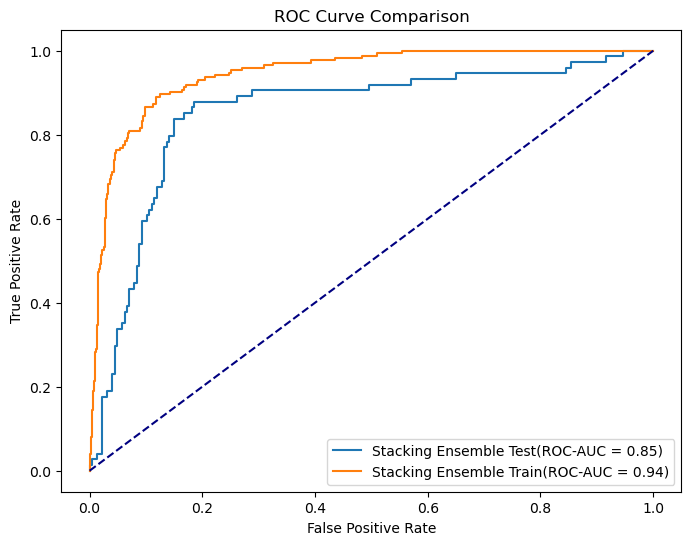

In [20]:
from sklearn.metrics import roc_curve

# Menghitung probabilitas untuk tiap model
y_proba_stack_test = final_stack.predict_proba(X_test)[:, 1]
y_proba_stack_train = final_stack.predict_proba(X_train)[:, 1]

# Menghitung ROC curve untuk tiap model
fpr_stack_test, tpr_stack_test, _ = roc_curve(y_test, y_proba_stack_test)
fpr_stack_train, tpr_stack_train, _ = roc_curve(y_train, y_proba_stack_train)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_stack_test, tpr_stack_test, label='Stacking Ensemble Test(ROC-AUC = %0.2f)' % roc_auc_score(y_test, y_proba_stack_test))
plt.plot(fpr_stack_train, tpr_stack_train, label='Stacking Ensemble Train(ROC-AUC = %0.2f)' % roc_auc_score(y_train, y_proba_stack_train))


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

## input data baru

In [21]:
# ============================
# INPUT DATA BARU (1 KLAIM)
# ============================

new_claim = {
    'months_as_customer': 120,
    'age': 45,
    'policy_state': 'OH',
    'policy_csl': '250/500',
    'policy_deductable': 1000,
    'policy_annual_premium': 1200,
    'umbrella_limit': 0,
    'insured_sex': 'MALE',
    'insured_education_level': 'College',
    'insured_occupation': 'sales',
    'insured_hobbies': 'chess',
    'insured_relationship': 'husband',
    'capital-gains': 0,
    'capital-loss': 0,
    'incident_type': 'Collision',
    'collision_type': 'Rear Collision',
    'incident_severity': 'Major Damage',
    'authorities_contacted': 'Police',
    'incident_state': 'OH',
    'incident_city': 'Columbus',
    'incident_hour_of_the_day': 22,
    'number_of_vehicles_involved': 3,
    'property_damage': 'YES',
    'bodily_injuries': 0,
    'witnesses': 0,
    'police_report_available': 'NO',
    'total_claim_amount': 85000,
    'injury_claim': 0,
    'property_claim': 20000,
    'vehicle_claim': 65000,
    'auto_year': 2018,

    # fitur hasil feature engineering
    # Karena feature engineering dilakukan di luar pipeline, maka fitur hasil ekstraksi perlu dimasukkan secara eksplisit saat prediksi
    'days_since_policy': 30,
    'unknown_property_damage': 0,
    'unknown_collision_type': 0,
    'unknown_police_report_but_severe_damage': 0,
    'high_claim_without_witnesses': 1,
    'multi_vehicles_no_injury': 1,
    'no_police_report_but_severe_damage': 1,
    'zip_prefix': '432',
    'auto_make_model': 'Toyota_Camry'
}

# Ubah ke DataFrame
new_claim_df = pd.DataFrame([new_claim])

In [22]:
# ============================
# PREDIKSI FRAUD
# ============================

proba_fraud = final_stack.predict_proba(new_claim_df)[0][1]
pred_label = final_stack.predict(new_claim_df)[0]

print(f"Probabilitas Fraud : {proba_fraud:.4f}")
print(f"Prediksi Kelas     : {'FRAUD' if pred_label == 1 else 'NON-FRAUD'}")

Probabilitas Fraud : 0.9410
Prediksi Kelas     : FRAUD


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
